<a href="https://colab.research.google.com/github/Ayushpatel2026/cnn-malaria/blob/main/MalariaDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import tensorflow as tf
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Input, BatchNormalization, Conv2D, MaxPool2D, Dense, Flatten

## **Data Preparation**

In [2]:

# load the data set and its info
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'] )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# the dataset is of 27558 cell images
# it is given as a dictionary with the keys 'image' and 'label'
# Label of 1 is no malaria parasite (uninfected), 0 is malaria parasite (infected)
# each image is 103 by 103 pixels by 3 (for rgb)
# it is not split already, we need to do that below
# # let us look at the data
for data in dataset[0].take(1):
  print(data)

In [3]:
def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
  DATASET_SIZE = len(dataset)

  # take from 0 to train_ratio*dataset_size
  train_dataset = dataset.take(int(train_ratio*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(train_ratio*DATASET_SIZE))

  # after removing train, take val_ratio*dataset_size
  val_dataset = val_test_dataset.take(int(val_ratio*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(val_ratio*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [4]:
# SPLIT the dataset

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

16534
5511
5513


## Dataset Visualization

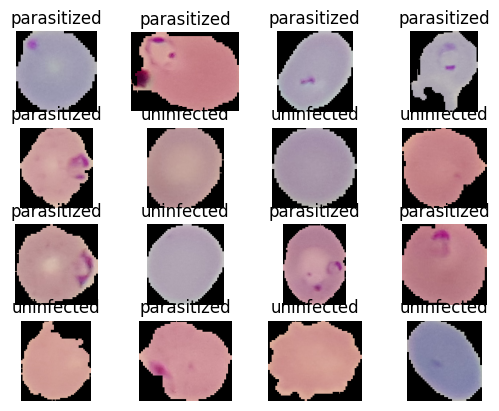

In [6]:
# take the first 16 images and the labels from the train_dataset
# and see what they look like - COOL STUFF!!
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis("off")

## Data Preprocessing

In [5]:
# first we need to resize

'''
WHY RESIZE?
The Malaria dataset consists of images with varying resolutions.
Resizing all images to a uniform size ensures consistency in input dimensions.

WHY 224?
 1. Convention and compatibility with pre-trained models
 2. Optimal tradeoff point between resolution and computational cost
 3. Just big enough to capture patterns but also not overfit

'''

# then, normalization step - divide by 255

'''
To be more in depth - we are using min max scaling here since we have known
max-min values. In general scaling the values so that they are between 0 and 1
is more computationally efficient and works well for non-linear activation
functions

X = (X - X_min)/(X_max - X_min)
Since our data is pixels ranging from 0 - 255
This becomes: X = (X - 0)/(255 - 0) = X/255
'''

IM_SIZE = 224
def resize_rescale(image, label):
  # note that the datatype will be changed to float32 here
  image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0
  return image, label

In [6]:
#Applies the resize_rescale function to each element (image, label pair) in the dataset
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
# for image, label in train_dataset.take(1):
#   print(image, label)

BATCH_SIZE = 32
# we want to shuffle the data at each epoch
# sample from buffer_size of 1024, small buffer means shuffling is less random
# prefetch - preload data while current batch is being processed
# improves latency and throughput, using additional memory to store prefetched elements.
train_dataset = train_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Creation


### Sequential API

In [7]:
'''
To start, we are implementing a simple LeNet model.
The layers are as follows:
  Conv2D layer - 5x5 kernel and 6 filters
  BatchNormalization layer - normalizes the activations of the previous layer for each batch
  MaxPool2D layer - 2x2 pool size and stride 2
  Conv2D layer - 5x5 kernal and 16 filters
  BatchNormalization
  MaxPool2D layer - 2x2 pool size and stride 2
  Flatten layer - converts 3D to a long 1D vector
  Dense layer - 100 neurons
  BatchNormalization
  Dense layer - 10 neurons
  BatchNormalization
  Dense layer - 2 neurons (for 2 classes - parasitized or uninfected)
'''

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1,
                           padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1,
                           padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid"),
   ])
lenet_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Functional API

In [13]:
# the output of the previous part is the input of the next part
# but the functional api allows us to have multiple outputs and multiple inputs

# feature extraction model
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input_Image")
x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
extract_features = MaxPool2D(pool_size=2, strides=2)(x)
feature_extractor_model = Model(func_input, extract_features, name="Feature_Extractor")
feature_extractor_model.summary()

# call the feature extractor model to use it as a layer here
# attach it to the classification layers to make the full model
x = feature_extractor_model(func_input)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="LeNet_Model")
lenet_model_func.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

Model: "LeNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Feature_Extractor (Functional)       │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Subclassing

In [17]:
# we create our own FeatureExtractor layer by extending the Layer class from keras
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size,
                        strides=strides, padding=padding, activation=activation)
    self.batch1 = BatchNormalization()
    self.pool1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv2 = Conv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides, padding=padding, activation=activation)
    self.batch2 = BatchNormalization()
    self.pool2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.batch2(x)
    x = self.pool2(x)

    return x
feature_sub_classed = FeatureExtractor(filters=16, kernel_size=3, strides=1,
                                       padding='valid', activation='relu', pool_size=2)

# the sub class we created can now be used as before in functional and sequential api's
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input_Image")
x = feature_sub_classed(func_input, training=True)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

lenet_model_subclassed = Model(func_input, func_output, name="LeNet_Model")
lenet_model_subclassed.summary()



Model: "LeNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor_10                 │ (None, 54, 54, 16)          │           2,896 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,670,057 (17.81 MB)

 Trainable params: 4,669,773 (17.81 MB)

 Non-trainable params: 284 (1.11 KB)

In [20]:
# can also create the Lenet model by extending the Model from tf.keras

class LenetModel(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(filters, kernel_size, strides, padding, activation, pool_size)

    self.flatten = Flatten()
    self.dense1 = Dense(100, activation="relu")
    self.batch1 = BatchNormalization()
    self.dense2 = Dense(10, activation="relu")
    self.batch2 = BatchNormalization()

    self.dense = Dense(1, activation="sigmoid")

  def call(self, x, training):
    x = self.feature_extractor(x, training=training)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch1(x)
    x = self.dense2(x)
    x = self.batch2(x)
    return x

lenet_model_class = LenetModel(filters=16, kernel_size=3, strides=1,
                                       padding='valid', activation='relu', pool_size=2)
lenet_model_class(tf.zeros((1, IM_SIZE, IM_SIZE, 3)), training=True)
lenet_model_class.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'lenet_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "lenet_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_13                 │ ?                           │           2,896 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,670,046 (17.81 MB)

 Trainable params: 4,669,762 (17.81 MB)

 Non-trainable params: 284 (1.11 KB)

## Model Training

### Callbacks

In [14]:
'''
A callback is an object that can perform an action at various stages of training

It allows us to customize the behaviour of a keras model during training, evaluation and inference

tf.keras.callbacks provides many built in callback classes such as History

But it also provides an abstract Callback class that we can use to make custom callbacks
'''

class LossCallback(Callback):

  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch number {} the model has a loss of {}".format(epoch + 1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch number {} the model has a loss of {}".format(batch + 1, logs["loss"]))

In [13]:
# CSV logger - log training information onto a separate CSV file
# this is a built in callback from tf.keras.callbacks
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [16]:
'''
EarlyStopping - built in callback that prevents overfitting automatically
Once the validation loss stabilizes, automatically stop training to prevent overfitting
'''
# monitor the val_loss
# min_delta - change less than this number is considered no improvement
# patience - wait for this many epochs with no improvement to stop
# mode = 'auto' automatically infers min and mix from the name of what we are monitoring
# we will take the best weights, when val_loss was lowest
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)


In [18]:
'''
Learning Rate Scheduler - built in from tf.keras.callbacks

Learning rate should be high enough at start to avoid getting stuck in local minimas
After certain number of epochs, LR should be small enough to avoid overshoot
'''

def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(scheduler, verbose=1)



### Training

In [8]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'),
           TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc')]

# we use binary cross entropy loss -
# because we have a binary classification problem
# use the classic ADAM optimizer
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics=metrics)
history = lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=[csv_callback, es_callback])

Epoch 1/10
176/517 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.7695 - auc: 0.8336 - fn: 220.4205 - fp: 302.7557 - loss: 0.4838 - precision: 0.7601 - recall: 0.8080 - tn: 1087.5796 - tp: 1221.2443

KeyboardInterrupt: 

In [1]:
# plot the training loss, val loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

NameError: name 'plt' is not defined

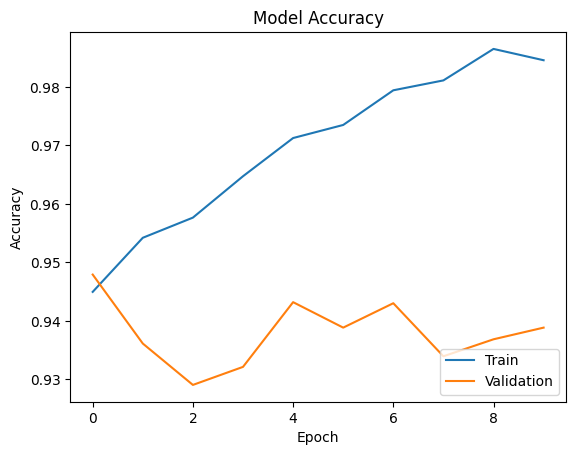

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

## Model Evaluation and Testing

In [26]:
test_dataset = test_dataset.batch(1) # test on single elements
lenet_model.evaluate(test_dataset)

5513/5513 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9381 - loss: 0.3030


[0.31458669900894165, 0.937420666217804]

In [ ]:
# visualizing the confusion matrix

labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

labels = np.array([i[0] for i in labels])
inp = np.array(inp)[:,0,...]

predicted = lenet_model.predict(inp)

'''
need to figure out the ideal threshold to minimize the false positives
For us - parasitic is 0 (negative), and uninfected is 1 (positive)
in the real world, it would be the opposite of this

we want the minimize the model predicting that someone is uninfected when they are infected
This would be pretty catatrophic.
Therefore we want to minimze the false positives for this model.
'''

threshold = 0.5

# all values predicted > threshold will be considered uninfected
cm = confusion_matrix(labels, predicted > threshold)
plt.figure(figsize=(8,8))
sns.heatmap('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [ ]:
# ROC Plot to choose ideal threshold

fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC Curve")
skip = 20
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


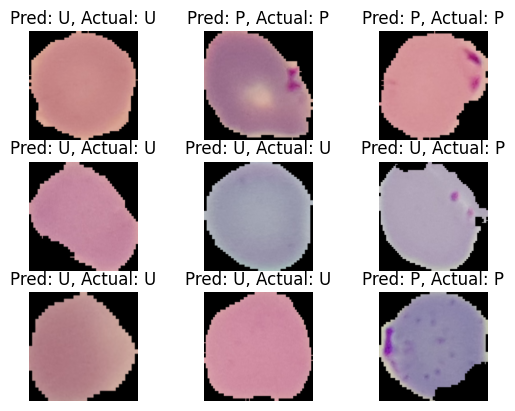

In [31]:
# we achieved 94% accuracy on test data set, now let us predict
# threshold of 0.6265 derived from ROC plot to minimize false positives
def parasite_or_not(x):
  if (x < 0.6265):
    return "P"
  else:
    return "U"

for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(f"Pred: {parasite_or_not(lenet_model.predict(image)[0][0])}, Actual: {parasite_or_not(label.numpy()[0])}")
  plt.axis("off")

## Save Model To Google Drive

In [40]:
filename="initial_malaria_model.keras"
lenet_model.save(filename)
lenet_model.save_weights("initial_malaria_model.weights.h5")

drive.mount('/content/drive')
!cp -r /content/initial_malaria_model.keras /content/drive/MyDrive/
!cp -r /content/initial_malaria_model.weights.h5 /content/drive/MyDrive/

Mounted at /content/drive


In [35]:
# load it
loaded_model = tf.keras.models.load_model(filename)
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)